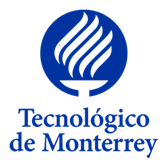

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 5

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Preparando Ambiente**

In [1]:
!pip install pyarrow

In [2]:
!pip install langchain

In [3]:
!pip install langchain-community

In [4]:
!pip install langchain-text-splitters

In [5]:
!pip install langchain-aws

In [1]:
# Importando librerias requeridas
import re
import json
import uuid
import logging
import io

import pyarrow.parquet as pq
import pandas as pd
import numpy as np

import s3fs
import boto3

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_aws import BedrockLLM


In [2]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
#logging.basicConfig(
#    filename='../Avance3_Equipo37_Select_Data_Job.log',
#    level=logging.INFO,
#    format='%(asctime)s %(levelname)-8s %(message)s',
#    datefmt='%Y-%m-%d %H:%M:%S'
#)

## **Cargando Conjunto de Datos**

In [3]:
SOURCE_AWS_BUCKET = 'volindo-hotel-data'
TARGET_DATA_FILE = f'hotel-clean-data-set/synthetic-data/hotel-data-set-4p.snappy.parquet'
SOURCE_FILE_DATA_SET = [
    f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/parquet4p/hotel-data-set-part0.snappy.parquet',
    f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/parquet4p/hotel-data-set-part1.snappy.parquet',
    f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/parquet4p/hotel-data-set-part2.snappy.parquet',
    f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/parquet4p/hotel-data-set-part3.snappy.parquet'
]

In [4]:
# Creando sistemas de archivos para bucket de S3
awsfs = s3fs.S3FileSystem()

# Creando cliente para AWS S3
s3_client = boto3.client('s3')


In [10]:
# Cargando conjunto de datos de hoteles como un Dataset multi-parte de Apache Parquet
dataframe_set = pd.DataFrame()
for file_name in SOURCE_FILE_DATA_SET:
    dataset = pq.ParquetDataset(file_name, filesystem=awsfs)
    table = dataset.read()
    dataframe = table.to_pandas()
    dataframe_set = pd.concat([dataframe_set, dataframe], ignore_index=True)

In [11]:
# Creando un Dataframe de Pandas para el analisis
dataframe_set.shape


(145067, 11)

## **Generación de Archivos de Datos Sintéticos para AWS Bedrock**

<img src="./Proyecto Integrador - RAG con Bedrock-Synthetics - Smart Travel Assistant KB v2.00 LangChain.drawio.png" alt="RAG Bedrock KB V1.00" />

El proceso para generar preguntas y respuestas sintéticas calificadas en **AWS Bedrock** es el siguiente:
1. Cargar el conjunto de datos de los datos con nivel de estrellas igual o mayor a 5. Cada muestra representa el contexto a usar para generar una pregunta
2. Extraer una muestra de más de 100 preguntas cubriendo todos los paises,
3. Crear prompt para generación de preguntas y respuestas,
4. Generar preguntas y respuestas usando el prompt de generación usando ***Mistral 7B de AWS Bedrock***,
5. Crear prompt para la evaluación de la fundamentalidad, o apego al contexto proporcionado (Grech, 2024),
6. Crear prompt para la evaluación de que tan relevante puede ser la pregunta para un usuario (Grech, 2024),
7. Evaluar cada pregunta y contexto generados usando el prompt de evaluación de fundamentalidad y ***Mistral 7B de AWS Bedrock***,
8. Evaluar cada pregunta generada usando el prompt de evaluación de relevancia y ***Mistral 7B de AWS Bedrock***,
9. Remover del conjunto de preguntas y respuestas finales las preguntas cuya calificación de fundamentalidad y/o relevancia sea menor a 4.


#### Generando muestras de datos de hoteles por país

In [37]:
# Generando 500 muestras aleatorias de 
dataframe = dataframe_set.groupby('CountryCode').sample(frac=0.0015)

In [8]:
# Liberando memoria usada por el conjunto de datos original
del dataframe_set

In [38]:
dataframe.shape

(202, 11)

In [39]:
dataframe.groupby(['CountryCode'])['CountryCode'].count()

CountryCode
AE     1
AR     1
AT     5
AU    10
BE     1
BG     1
BR     2
CA     3
CH     2
CN    13
CO     1
CY     1
CZ     2
DE     7
DO     1
EG     1
ES    11
FI     1
FR     9
GB    26
GR     7
HR     7
HU     1
ID     5
IE     2
IN     5
IT    13
JP     2
KH     1
KR     1
LK     1
MA     2
ME     1
MX     3
MY     1
NL     2
NZ     3
PH     1
PL     1
PT     4
RO     1
RS     1
RU     2
SA     1
SE     1
TH     5
TR     5
TW     1
US    15
VN     2
ZA     6
Name: CountryCode, dtype: int64

#### Configurando modelo para generar datos sintéticos

In [15]:
# Configurando el modelo generativo Mistral 7B
model_kwargs_premier = {'temperature': 0, 'top_p': 0.7, 'top_k': 50, 'max_tokens': 3000}
llm = BedrockLLM(model_id='mistral.mistral-7b-instruct-v0:2', model_kwargs=model_kwargs_premier)

In [16]:
# Creando plantilla del prompt para generación de preguntas
template = '''
You are a helpful travel assistant.
Your task is to write a one factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question should be formulated in the same style as questions users could ask in a search engine.
This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: {context}\n
Output:::
'''

generation_prompt = PromptTemplate.from_template(template)

generation_chain = generation_prompt | llm | StrOutputParser()

#### Configurando modelos para generar críticas de datos sintéticos

In [17]:
# Creando plantilla para crítica del nivel de fundamentalidad
groundedness_critique_template = '''
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating)
Total rating: (your rating)

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: '''

groundedness_critique_prompt = PromptTemplate.from_template(
    groundedness_critique_template
)

# Creando agente de crítica del nivel de fundamentalidad
groundedness_critique_agent = groundedness_critique_prompt | llm

# Creando plantilla para crítica del nivel de relevancia
relevance_critique_template = '''
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to travel assistants helping people to make their travel arrangements.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating)
Total rating: (your rating)

Now here is the question.

Question: {question}\n
Answer::: '''

relevance_critique_prompt = PromptTemplate.from_template(
    relevance_critique_template
)

# Creando agente de crítica del nivel de relevancia
relevance_critique_agent = relevance_critique_prompt | llm


#### Cargando datos de referencia para generar datos sintéticos

In [41]:
# Cargando archivo con los códigos de país y sus nombres. Se van a remover las columnas de códigos alfabético
# de 3 caracteres y numérico por que no se necesitan para preparar el texto extendido de la descripción 
ccdf_full = pd.read_csv('./country-code.csv')
ccdf_full.loc[ccdf_full.isna().any(axis=1),'Alpha2'] = 'NA'
ccdf = ccdf_full.drop(['Alpha3','UNCode'],axis=1)
# Usando el código alfabético del país como índice y creando un diccionario con el conjunto de datos
ccdf = ccdf.set_index('Alpha2')
ccdict = ccdf.to_dict('index')


#### Generanndo preguntas y respuestas sintéticas con sus evaluaciones

In [ ]:
subi = 0
dataframe_synthetic = pd.DataFrame(
    columns=[
        'question',
        'answer',
        'groundedness_score',
        'groundedness_eval',
        'relevance_score',
        'relevance_eval']
)
# Generando preguntas y respuestas sintéticas
for row in dataframe.itertuples():
    # Usando el nombre completo del país si código del país del registro existe en el
    # diccionario de códigos y nombres 
    long_country_name = ''
    if row.CountryCode in ccdict and ccdict[row.CountryCode]['Country'] is not None:
        long_country_name = ccdict[row.CountryCode]['Country']

    hotel_desc = \
        row.HotelName.title() + \
        'is located in ' + \
        row.CityName + ', ' + long_country_name +'. ' + \
        row.Description
    
    # Generando pregunta y respuesta sintética
    response = generation_chain.invoke({'context': hotel_desc})    
    question = response.split("Factoid question: ")[1].split("Answer: ")[0].strip()
    answer = response.split("Answer: ")[1].strip()
    
    # Generando críticas y calificaciones
    groundedness_evaluation = groundedness_critique_agent.invoke(
        {"context": hotel_desc, "question": question}
    )
    relevance_evaluation = relevance_critique_agent.invoke(
        {"question": question}
    )
    
    # La pregunta y la respuesta se agrega al conjunto de datos si:
    # 1) fue posible generar las evaluaciones de fundamentalidad y relevancia
    # 2) obtuvo una calificación de 4 o más en ambas evaluaciones
    if ('Evaluation: ' in groundedness_evaluation and
        'Total rating: ' in groundedness_evaluation and
        'Evaluation: ' in relevance_evaluation and
        'Total rating: ' in relevance_evaluation):
        groundedness_score = int(groundedness_evaluation.split('Total rating: ')[1][0].strip())
        groundedness_eval = groundedness_evaluation.split('Total rating: ')[0].split(
            'Evaluation: '
        )[1].strip()

        relevance_score = int(relevance_evaluation.split('Total rating: ')[1][0].strip())
        relevance_eval = relevance_evaluation.split('Total rating: ')[0].split(
            'Evaluation: '
        )[1].strip()    

        if (groundedness_score >= 4 and relevance_score >= 4):
            # Almacenar registro si ambas calificaciones son mayores a 4
            dataframe_synthetic = pd.concat(
                [
                    dataframe_synthetic,
                    pd.DataFrame(
                        [{
                            'question': question,
                            'answer': answer,
                            'groundedness_score': groundedness_score,
                            'groundedness_eval': groundedness_eval,
                            'relevance_score': relevance_score,
                            'relevance_eval': relevance_eval
                        }]
                    )
                ],
                ignore_index=True
            )
    else:
        print(f'Registro {subi} no genero críticas.')
        
    # Imprimiendo cuenta de registros procesados
    # El ciclo termina una vez procesados 1000 registros
    subi += 1
    #print(f'{subi} registros procesados.', end='\r')
    #if subi > 4:
    #    break


Registro 5 no genero críticas.
Registro 14 no genero críticas.
Registro 41 no genero críticas.
Registro 113 no genero críticas.
Registro 258 no genero críticas.
Registro 260 no genero críticas.
Registro 274 no genero críticas.
Registro 288 no genero críticas.
Registro 349 no genero críticas.
Registro 361 no genero críticas.


In [ ]:
dataframe_synthetic.shape

(426, 6)

In [ ]:
dataframe_synthetic.head(20)

#### Salvando datos sintéticos

In [22]:
out_buffer = io.BytesIO()
dataframe_synthetic.to_parquet(out_buffer, index=False)
response = s3_client.put_object(
    Bucket=SOURCE_AWS_BUCKET,
    Key=TARGET_DATA_FILE,
    Body=out_buffer.getvalue()
)
status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
if status != 200:
    print(f'S3 Bucket put failed - {status}')


## **Conclusiones**


## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* Aksitov, R., Miryoosefi, S., Li, Z., Li, D., Babayan, S., Kopparapu, K., Fisher, Z., Guo, R., Prakash, S., Srinivasan, P., Zaheer, M., Yu, F., & Kumar, S. (2023). ReST meets ReAct: Self-Improvement for Multi-Step Reasoning LLM Agent. ArXiv (Cornell University). https://doi.org/10.48550/arxiv.2312.10003

* Grech, C. (2024, 16 de febrero). Evaluating RAG Performance: A Comprehensive Guide. Medium. https://christiangrech.medium.com/evaluating-rag-performance-a-comprehensive-guide-b1d8f903b7ad

